In [1]:
import os
import shutil
from __future__ import division
from Bio.Application import _Option, AbstractCommandline, _Switch
%matplotlib inline

In [2]:
class PopulationsCommandLine(AbstractCommandline):
    def __init__(self, cmd="populations", **kwargs):
        """
        # Any populations option and switch
        >>> cline_args = {'b': 'fastq',
        ...               'P': '../../dan_data/OBY01_1.fil.fq_1',
        ...               'M': '../../dan_data/OBY01_1.fi/M_tests/M_1',
        ...               's': 1,
        ...               'B': 6,
        ...               'W': 1,
        ...               'e': 3,
        ...               't': True,
        ...               'v': True}
        
        # This creates a command line object
        >>> populations_cline = PopulationsCommandLine(**cline_args)
        
        # This prints a string representation
        >>> print populations_cline 
        populations -t fastq -f ../../dan_data/OBY01_1.fil.fq_1 -o ../../dan_data/OBY01_1.fi/M_tests/M_1 -i 1 -m 6 -M 1 -p 3 -r -d
        
        # This runs populations
        >>> stdout, stderr = populations_cline()
        
        """
        
        self.parameters = [
            _Option(["-b", "b"],
                    "Batch ID to examine when exporting from the catalog",
                    is_required=True,
                    equate=False),
            _Option(["-P", "P"],
                    "path to the Stacks output files",
                    is_required=True,
                    filename=True,
                    equate=False),
            _Option(["-M", "M"],
                    "path to the population map, a tab separated file describing which individuals belong in which population.",
                    is_required=True,
                    filename=True,
                    equate=False),
            _Option(["-s", "s"],
                    "output a file to import results into an SQL database.",
                    is_required=False,
                    equate=False),
            _Option(["-B", "B"],
                    "specify a file containing Blacklisted markers to be excluded from the export.",
                    is_required=False,
                    filename=True,
                    equate=False),
            _Option(["-W", "W"],
                    "specify a file containing Whitelisted markers to include in the export.",
                    is_required=False,
                    filename=True,
                    equate=False),
            _Option(["-e", "e"],
                    "restriction enzyme, required if generating 'genomic' output.",
                    is_required=False,
                    equate=False),
            _Option(["-t", "t"],
                    "number of threads to run in parallel sections of code.",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),  
            _Switch(["-v", "v"],
                    "print program version."),
            _Switch(["-h", "h"],
                    "display this help messsage"),

            
            # Merging and Phasing:
            _Switch(["--merge_sites", "-merge_sites", "merge_sites"],
                    "merge loci that were produced from the same restriction enzyme cutsite (requires reference-aligned data)."), 
            _Switch(["--merge_prune_lim", "-merge_prune_lim", "merge_prune_lim"],
                    "when merging adjacent loci, if at least X% samples posses both loci prune the remaining samples out of the analysis."),
            
            # Data Filtering:
            _Option(["-r", "r"],
                    "minimum percentage of individuals in a population required to process a locus for that population.",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,float),
                    equate=False),
            _Option(["-p", "p"],
                    "minimum number of populations a locus must be present in to process a locus.",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),
            _Option(["-m", "m"],
                    "specify a minimum stack depth required for individuals at a locus.",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),
            _Option(["-f", "f"],
                    "specify a correction to be applied to Fst values: 'p_value', 'bonferroni_win', or 'bonferroni_gen'.",
                    is_required=False,
                    equate=False),
            _Option(["--min_maf", "-min_maf", "min_maf"],
                    "specify a minimum minor allele frequency required to process a nucleotide site at a locus (0 < min_maf < 0.5).",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,float),
                    equate=False),
            _Option(["--max_obs_het", "-max_obs_het", "max_obs_het"],
                    "specify a maximum observed heterozygosity required to process a nucleotide site at a locus",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,float),
                    equate=False),
            _Option(["--p_value_cutoff", "-p_value_cutoff", "p_value_cutoff"],
                    "required p-value to keep an Fst measurement (0.05 by default). Also used as base for Bonferroni correction",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,float),
                    equate=False),
            _Option(["--lnl_lim", "-lnl_lim", "lnl_lim"],
                    "filter loci with log likelihood values below this threshold",
                    is_required=False,
                    equate=False),
            _Switch(["--write_single_snp", "-write_single_snp", "write_single_snp"],
                    "restrict data analysis to only the first SNP per locus"),
            _Switch(["--write_random_snp", "-write_random_snp", "write_random_snp"],
                    "restrict data analysis to one random SNP per locus"),
            
            
            ## Add missing options here
            
                    
            ## Fstats
            _Switch(["--fstats", "-fstats", "fstats"],
                    "enable SNP and haplotype-based F statistics."), 
            
                    
            # Bootstrap Resampling: 
            _Switch(["--bootstrap", "-bootstrap", "bootstrap"],
                    "turn on boostrap resampling for all smoothed statistics."),
            _Switch(["--bootstrap_pifis", "-bootstrap_pifis", "bootstrap_pifis"],
                    "turn on boostrap resampling for smoothed SNP-based Pi and Fis calculations.."),
            _Switch(["--bootstrap_fst", "-bootstrap_fst", "bootstrap_fst"],
                    "turn on boostrap resampling for smoothed Fst calculations based on pairwise population comparison of SNPs.."),
            _Switch(["--bootstrap_div", "-bootstrap_div", "bootstrap_div"],
                    "turn on boostrap resampling for smoothed haplotype diveristy and gene diversity calculations based on haplotypes."),
            _Switch(["--bootstrap_phist", "-bootstrap_phist", "bootstrap_phist"],
                    "turn on boostrap resampling for smoothed Phi_st calculations based on haplotypes."),
            _Option(["--bootstrap_reps", "-bootstrap_reps","bootstrap_reps"],
                    "number of bootstrap resamplings to calculate (default 100)",
                    is_required=False,
                    checker_function=lambda value : isinstance(value,int),
                    equate=False),
            _Option(["--bootstrap_wl", "-bootstrap_wl","bootstrap_wl"],
                    "only bootstrap loci contained in this whitelist.",
                    is_required=False,
                    filename=True,
                    equate=False),
            
            # File ouput options:
            _Switch(["--ordered_export", "-ordered_export", "ordered_export"],
                    "if data is reference aligned, exports will be ordered; only a single representative of each overlapping site.."),
            _Switch(["--genomic", "-genomic", "genomic"],
                    "output each nucleotide position (fixed or polymorphic) in all population members to a file."),
            _Switch(["--fasta", "-fasta", "fasta"],
                    "output full sequence for each unique haplotype, from each sample locus in FASTA format, regardless of plausibility."),
            _Switch(["--fasta_strict", "-fasta_strict", "fasta_strict"],
                    "output full sequence for each haplotype, from each sample locus in FASTA format, only for biologically plausible loci."),
            _Switch(["--vcf", "-vcf", "vcf"],
                    "output SNPs in Variant Call Format (VCF)."),
            _Switch(["--vcf_haplotypes", "-vcf_haplotypes", "vcf_haplotypes"],
                    "output haplotypes in Variant Call Format (VCF)."),
            _Switch(["--genepop", "-genepop", "genepop"],
                    "output results in GenePop format."),
            _Switch(["--structure", "-structure", "structure"],
                    "output results in Structure format."),
            _Switch(["--phase", "-phase", "phase"],
                    "output genotypes in PHASE format."),
            _Switch(["--fastphase", "-fastphase", "fastphase"],
                    "output genotypes in fastPHASE format."),
            _Switch(["--beagle", "-beagle", "beagle"],
                    "output genotypes in Beagle format."),
            _Switch(["--beagle_phased", "-beagle_phased", "beagle_phased"],
                    "output haplotypes in Beagle format."),
            _Switch(["--plink", "-plink", "plink"],
                    "output genotypes in PLINK format."),
            _Switch(["--hzar", "-hzar", "hzar"],
                    "output genotypes in Hybrid Zone Analysis using R (HZAR) format."),
            _Switch(["--phylip", "-phylip", "phylip"],
                    "output nucleotides that are fixed-within, and variant among populations in Phylip format for phylogenetic tree construction."),
            _Switch(["--phylip_var", "-phylip_var", "phylip_var"],
                    "include variable sites in the phylip output encoded using IUPAC notation."),
            _Switch(["--phylip_var_all", "-phylip_var_all", "phylip_var_all"],
                    "include all sequence as well as variable sites in the phylip output encoded using IUPAC notation."),
            _Switch(["--treemix", "-treemix", "treemix"],
                    "output SNPs in a format useable for the TreeMix program (Pickrell and Pritchard)."),
            
            # Debugging:
            _Switch(["--verbose", "-verbose", "verbose"],
                    "turn on additional logging."),
            _Switch(["--log_fst_comp", "-log_fst_comp", "log_fst_comp"],
                    "log components of Fst/Phi_st calculations to a file.")]
        AbstractCommandline.__init__(self, cmd, **kwargs) 

In [3]:
def make_and_run_populations_cline(Setup_dict, param, value):
    
    """
    Makes and runs the command line using the PopulationsCommandLine class
    """
    batch_params = {}
    
    populations_params = ['b','P','M','s','B','W','e','t','v','h','merge_sites','merge_prune_lim','r','p','m','f','min_maf','max_obs_het','p_value_cutoff','lnl_lim',
              'write_single_snp','write_random_snp','fstats','k','window_size','bootstrap','bootstrap_pifis','bootstrap_fst','bootstrap_div','bootstrap_phist',
              'bootstrap_reps','bootstrap_wl','ordered_export','genomic','fasta','fasta_strict','vcf','vcf_haplotypes','enepop','structure','phase',
              'fastphase','beagle','beagle_phased','plink','hzar','phylip','phylip_var','phylip_var_all','treemix','verbose','log_fst_comp','-b','-P','-M','-s','-B','-W','-e','-t','-v','-h','--merge_sites','--merge_prune_lim','-r','-p','-m','-f','--min_maf','--max_obs_het','--p_value_cutoff','--lnl_lim',
              '--write_single_snp','--write_random_snp','--fstats','-k','--window_size','--bootstrap','--bootstrap_pifis','--bootstrap_fst','--bootstrap_div','--bootstrap_phist',
              '--bootstrap_reps','--bootstrap_wl','--ordered_export','--genomic','--fasta','--fasta_strict','--vcf','--vcf_haplotypes','--genepop','--structure','--phase',
              '--fastphase','--beagle','--beagle_phased','--plink','--hzar','--phylip','--phylip_var','--phylip_var_all','--treemix','--verbose','--log_fst_comp']
    
    
     
    args = {}
    
    ## Pass the values of the Test parameters
    
    if param == "p":
    
        args["-p"] = value
        args["-r"] = Setup_dict["r_default"]
        args["-m"] = Setup_dict["m_default"]
    
    elif param == "r":
    
        args["-p"] = Setup_dict["p_default"]
        args["-r"] = value
        args["-m"] = Setup_dict["m_default"]
    
    elif param == "m":
    
        args["-p"] = Setup_dict["p_default"]
        args["-r"] = Setup_dict["r_default"]
        args["-m"] = value
            
    
    for parameter in Setup_dict:
        if parameter in populations_params:
            args[parameter] = Setup_dict[parameter]
     
    args["--vcf"] = True ## overrides the input dictionary as the vcf is a necassary output for getting plotting data
    
    ## Make command line ---------------------------------------------------------------------------
    

    cline = PopulationsCommandLine(**args)
        
    if Setup_dict['run_cline_switch'] == 1:
        stderr, stdout = cline()        

        
    return cline

In [4]:
def sample_Avcov_from_vcf(vcf_path):
    
    """
    Finds the average coverage of each sample in a vcf file.
    Just requires the vcf path as input. Not, it does not incorporate information
    about missing loci, the average is only calculated from those loci called is each sample. 
    
    """

    import vcf
    import numpy as np
    
    sample_cov = {}
    
    for record in vcf.Reader(open(vcf_path, 'r')):
        samples_called = 0
        for sample in record.samples:
            if sample.called  == True:
                samples_called += 1
                
                if sample.sample not in sample_cov.keys():
                    sample_cov[sample.sample] = []
                else:
                    sample_cov[sample.sample].append(sample['DP'])
    
    sample_avgs = {}

    for sample in sample_cov.keys():
        sample_avgs[sample] = np.round(np.mean(sample_cov[sample]), 2)
    
    return sample_avgs
        

In [5]:
def Missing_data_finder(vcf_path):
    
    import vcf
    import numpy as np
    
    Missing_data_dict = {}
    locus_counter = 0
    
    for record in vcf.Reader(open(vcf_path, 'r')):
        locus_counter += 1
        for sample in record.samples:
            if sample.sample not in Missing_data_dict:
                Missing_data_dict[sample.sample] = 0
            if sample.called  == False:
                Missing_data_dict[sample.sample] += 1
    
    for sample in Missing_data_dict:
        Missing_data_dict[sample] = np.round(float(Missing_data_dict[sample]/locus_counter), 2)
                
    return Missing_data_dict

In [6]:
def heterozygostity_finder(vcf_path):
    import numpy as np
    import vcf
    
    sample_het_loci = {}
    sample_called_loci = {}
    sample_heterozygosities = {}

    for record in vcf.Reader(open(vcf_path, 'r')):
        for sample in record.samples:
            if sample.sample not in sample_het_loci:
                sample_het_loci[sample.sample] = 0
            if sample.sample not in sample_called_loci:
                sample_called_loci[sample.sample] = 0
            if sample.called:
                sample_called_loci[sample.sample] += 1
            if sample.is_het:
                sample_het_loci[sample.sample] += 1

    for sample in sample_het_loci:
        sample_heterozygosities[sample] = np.round(sample_het_loci[sample]/sample_called_loci[sample],2)
    
    return sample_heterozygosities, sample_called_loci

In [7]:
#vcf_path = "/home/djeffrie/Data/Caspers_data/populations/r_075_goodsamples/batch_1c.vcf.altered"

def Per_locus_stats(vcf_path, sample_list):
    
    import numpy as np
    import vcf
    
    locus_dict = {}
    
    print vcf_path
    
    for record in vcf.Reader(open(vcf_path, 'r')):

        LocID = "%s_%s" % (record.ID, record.POS)
        locus_dict[LocID] = {}
        REF = record.REF        
        
        locus_coverages = []
        het_samples = 0
        sample_count = 0
        REF_counts = 0
        
        for sample in record.samples:
            if sample.sample in sample_list:
                if sample.called:
                    #print LocID, "is called, sample ID should be > 0"
                    sample_count += 1
                    locus_coverages.append(sample['DP'])
                    REF_counts += sample.gt_bases.count(REF)
                if sample.is_het:
                    het_samples += 1

        locus_dict[LocID]["N_samples_called"] = sample_count
        
        if sample_count > 0:
            locus_dict[LocID]["Major_freq"] = REF_counts/(sample_count*2)
            locus_dict[LocID]["Average_coverage"] = np.round(np.mean(locus_coverages),2)
            locus_dict[LocID]["Loc_heterozygosity"] = het_samples/sample_count
        else:
            locus_dict[LocID]["Major_freq"] = 0 ## this may cause problems downstream, look out for this! Need to deal with it cos this will be common in p_tests
            locus_dict[LocID]["Average_coverage"] = 0
            locus_dict[LocID]["Loc_heterozygosity"] = 0
        
    
    
    return locus_dict


In [8]:
def Nsnp_Avcov_plotter(Sample_data, group_info):

    import math
    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib import cm
    ## Get data for groups so this can be plotted separately

    Mean_N_SNPs_per_sample = {}
    Mean_coverage_per_sample = {}
    
    fig = plt.figure(figsize = (7*(len(Sample_data)),10))
    
    param_plot_counter = 0
        
    N_params = 0
    
    for param in Sample_data:
        if len(Sample_data[param]) > 0:
            N_params += 1
    
    for param in Sample_data:
        
        if len(Sample_data[param]) > 0:
    
            Mean_N_SNPs_per_sample[param] = {}
            Mean_coverage_per_sample[param] = {}
            param_plot_counter += 1
            
            for value in Sample_data[param]:
                
                if len(Sample_data[param][value]) > 0:
                    
                    
                    Mean_N_SNPs_per_sample[param][value] = {}
                    N_SNPs_per_sample_group = {}
                    Mean_coverage_per_sample[param][value] = {}
                    Coverage_per_sample_group = {}

                    if len(Sample_data[param][value]) >= 1:

                        #print param, value, Sample_data[param][value].keys()

                        for sample in Sample_data[param][value]:
                            for group in group_info:
                                if sample in group_info[group]:
                                    sample_group = group
                            #print Sample_data[param][value][sample]
                            if sample_group not in N_SNPs_per_sample_group:
                                N_SNPs_per_sample_group[sample_group] = []
                                Coverage_per_sample_group[sample_group] = []
                            N_SNPs_per_sample_group[sample_group].append(Sample_data[param][value][sample]["N_snps"])
                            Coverage_per_sample_group[sample_group].append(Sample_data[param][value][sample]["Average_coverage"])
                    for group in N_SNPs_per_sample_group:
                        Mean_N_SNPs_per_sample[param][value][group] = np.round(np.mean(N_SNPs_per_sample_group[group]))
                        Mean_coverage_per_sample[param][value][group] = np.round(np.mean(Coverage_per_sample_group[group]))

            
            #Now plot the data for all groups on each graph separately.

            blues = cm.get_cmap("Blues")

            ax1 = fig.add_subplot(1,N_params,param_plot_counter)


            group_counter = 1
            for group in group_info:
                group_color = blues(group_counter/len(group_info))
                group_counter += 1

                for param in Mean_N_SNPs_per_sample:
                    group_snp_vals = []
                    group_cov_vals = []

                    for val in Mean_N_SNPs_per_sample[param]:
                        if Mean_N_SNPs_per_sample[param][val] > 1:

                            group_snp_vals.append(Mean_N_SNPs_per_sample[param][val][group])
                            group_cov_vals.append(Mean_coverage_per_sample[param][val][group])

                ax1.scatter(range(1,len(Mean_N_SNPs_per_sample[param].keys())+1,1), group_snp_vals, color = group_color)
                ax1.plot(range(1,len(Mean_N_SNPs_per_sample[param].keys())+1,1), group_snp_vals, color = group_color, linewidth = 2, label = "%s Nsnps" % group)
                ax1.set_ylabel("Mean number of SNPs per sample")
                #ax1.legend()

                ax2 = ax1.twinx()
                ax2.scatter(range(1,len(Mean_coverage_per_sample[param].keys())+1,1), group_cov_vals, color = group_color, marker = "D")
                ax2.plot(range(1,len(Mean_coverage_per_sample[param].keys())+1,1), group_cov_vals, color = group_color, linewidth = 2, linestyle = "dashed", label = "%s Cov" % group)
                ax2.set_ylabel("Mean coverage per sample")
                
                if group_counter != len(group_info):
                    ax2.axes.get_yaxis().set_visible(False)
                
                plt.xlabel("%s value" % param)
                plt.xticks(range(1,len(Mean_N_SNPs_per_sample[param].keys())+1,1), sorted(Mean_N_SNPs_per_sample[param].keys()))
                plt.title("Parameter = %s" % param)

            ax1.legend(loc = "upper left")
            ax2.legend(loc = "upper right")
    plt.tight_layout()
    plt.show()

In [66]:
def Cov_vs_Het_single(Sample_data, param, value):

    """
    Sample_data = the dictionary returned by Incremental_Pop
    param = the parameter to plot for "p", r" or "m"
    value = the value of the parameter used. Note** For r no decimal place should be used, e.g. 0.75 becomes 075.
    
    Outputs a plot of heterozygosity versus coverage for each sample and plots a regression line. A positive skew in this line suggests that
    low coverage is impacting the ability of stacks to make accurate genotype calls for heterozygous loci. 
    
    """
    
    
    Sample_level_data = Sample_data

    import numpy as np
    from matplotlib import pyplot as plt
    from matplotlib import cm


    param = "r"
    value = "075"


    blues = cm.get_cmap("Blues")
    fig = plt.figure(figsize = (10,10))

    Av_covs = []
    Av_hets = []
    Sample_labels = []

    for sample in Sample_level_data[param][value]:
        if len(Sample_level_data[param][value][sample]) > 1:
            Av_covs.append(Sample_level_data[param][value][sample]['Average_coverage'])
            Av_hets.append(Sample_level_data[param][value][sample]['Heterozygosity'])
            Sample_labels.append(sample)

    plt.plot(Av_hets, Av_covs, '.')

    ## Plot sample names on there, these will likely be too small to read unless viewing the fig in pdf format though.
    for i in range(0, len(Sample_labels)):
        plt.text(Av_hets[i], Av_covs[i], Sample_labels[i], size = 5)

    ## Plot fit line, if this has an upward tragectory then there is likely a problem with genotype calling due to low coverage.        
    m, b = np.polyfit(Av_hets, Av_covs, 1)
    plt.plot(Av_hets, [(i*m + b) for i in Av_hets] , '-', color= 'red')

    plt.xlabel("Average sample heterozygosity")
    plt.ylabel("Average sample coverage")

    plt.show()


    

In [9]:
def Missing_data_plotter(Sample_data, group_info):

    import numpy as np
    from matplotlib import cm
    from matplotlib import pyplot as plt

    colours = cm.get_cmap("Set1")
    
    N_params = 0
    for param in Sample_data:
        if len(Sample_data[param]) > 0:
            N_params += 1
    
    param_counter = 1
    for param in Sample_data:
        if len(Sample_data[param]) > 0:
            
            Missing_per_sample = {}
            Missing_all_samples = []
            Missing_per_group = {}
            Mean_missing_per_sample = {}
            Mean_missing_per_group = {}
            Sample_labs = []
            
            for value in Sample_data[param]:
                if len(Sample_data[param][value]) > 0:
                    for group in group_info:
                        Missing_per_group[group] = []
                        for sample in Sample_data[param][value]:
                            if sample in group_info[group]:
                                if sample not in Missing_per_sample:
                                    Missing_per_sample[sample] = []
                                    Sample_labs.append(sample)
                                Missing_per_sample[sample].append(Sample_data[param][value][sample]["Missing_data"])
                                Missing_per_group[group].append(Missing_per_sample[sample])

            for sample in Missing_per_sample:
                Missing_all_samples.append(Missing_per_sample[sample])

            fig = plt.figure(figsize=(0.3*(len(Sample_labs)), 10*N_params))
            

            fig.add_subplot(N_params,1,param_counter)

            plt.boxplot(Missing_all_samples)
            plt.xticks(range(1, len(Sample_labs)+1, 1), Sample_labs, rotation = "vertical")
            plt.ylabel("Proportion of loci missing")
            plt.title("Parameter = %s" % param)
            plt.grid(b=True, which='both', color='0.65',linestyle='-', axis = "x")
            plt.hlines(np.mean([np.mean(i) for i in Missing_all_samples]),1,len(Sample_labs), color ="grey", linestyle = "dashed", label = "All")

            group_counter = 1
            for group in Missing_per_group:
                mycolour = colours(group_counter/len(Missing_per_group))
                plt.hlines(np.mean([np.mean(i) for i in Missing_per_group[group]]),1,len(Sample_labs), color =mycolour, label = group, linewidth = 2)

                group_counter += 1

            plt.legend(loc='upper left', title = "Means")

            param_counter += 1
            plt.show()

In [67]:
def Missing_data_plotter_single(Sample_level_data, group_dict, param, value):
    """
    Sample_level_data = Data dictionary returned by Incremental_Pop
    group_dict = Group_info dictionary returned by Incremental_Pop
    param = the parameter to plot for "p", r" or "m"
    value = the value of the parameter used. Note** For r no decimal place should be used, e.g. 0.75 becomes 075.
    
    Outputs a barplot showing the amount of missing data for the specified analyses for each population in the dataset.
    
    """
    Missing = []
    Sample_labels = []

    group_counter = 1
    sample_counter = 1
    N_samples = 0
    fig = plt.figure(figsize=(25,10)) ## adjust plot size for number of samples

    Sample_labels = []

    for group in group_dict:

        group_color = blues(group_counter/len(group_dict))

        for sample in Sample_level_data[param][value]:
            if Sample_level_data[param][value][sample]["Pop"] == group:
                if len(Sample_level_data[param][value][sample]) > 1:
                    Sample_labels.append(sample)
                    plt.bar(sample_counter, Sample_level_data[param][value][sample]["Missing_data"], color = group_color, edgecolor = "White", align = "center")

                    sample_counter += 1

        group_counter += 1

    plt.xticks(range(1,len(Sample_labels)+1,1), Sample_labels, rotation = "vertical")
    plt.show()


In [65]:
def Incremental_Pop(Analysis_parameters):
    
    import vcf
    import sys
    import os
    
    ## Inside Incremental_Populations function.

    ## Making the necassary directories ---------------------------------------------------------------------------------

    p_default = Analysis_parameters["p_default"]
    r_default = 0.75
    m_default = 3

    outdirs = []

    for param in  Analysis_parameters['parameters']: 
        
        if len(Analysis_parameters["%s_vals" % param]) > 0:

            for value in Analysis_parameters["%s_vals" % param]:

                indirname = Analysis_parameters["P"]

                if isinstance(value, float):
                    dirvalue = str(value).replace(".", "")
                    outdirname = '%s/%s_tests/%s_%s'%(Analysis_parameters["Populations_test_dir_path"],param,param,str(dirvalue))
                    outdirs.append(outdirname)

                else:
                    outdirname = '%s/%s_tests/%s_%s'%(Analysis_parameters["Populations_test_dir_path"],param,param,str(value))
                    outdirs.append(outdirname)


                if not os.path.exists(outdirname):
                    try:
                        os.makedirs(outdirname)
                    except:
                        os.mkdir(outdirname)

                ## Make and run the command line

                if Analysis_parameters["run_cline_switch"] == 1:
                    print "## Running command lines ##"

                pop_cline = make_and_run_populations_cline(Analysis_parameters,param, value)

                print "%s    ## FINISHED " % pop_cline

                ## Move files 

                if Analysis_parameters["run_cline_switch"] == 1:
                    for fil in os.listdir(Analysis_parameters1["P"]):

                        pop_outfile = "%s/%s" % (Analysis_parameters1["P"],fil)
                        pop_testdir_outfile = "%s/%s" % (outdirname, fil)

                        if "batch_%s" % Analysis_parameters1["b"] in fil and "catalog" not in fil:
                            os.rename(pop_outfile, pop_testdir_outfile)
                        #if "populations.log" in fil:
                            #os.rename(pop_outfile, pop_testdir_outfile)
                    print "Files moved to %s" % outdirname
            
    
    
    ## Next get the data for plotting ## --------------------------------------------------------------------------------
    
    print "##### Getting and plotting the data ###### "
    
    ## Make two dictionaries, one for sample level data, and one for locus level data. 

    Sample_level_data={}
    Locus_level_data={}
    group_dict = {}
    Samples = []

    Popmap = Analysis_parameters['M'] ## Get the popmap file used in Stacks for the population information

    for line in open(Popmap, 'r').readlines():
        sample_name = line.split()[0]
        pop_name = line.split()[1]

        if pop_name not in group_dict:
            group_dict[pop_name] = []
        group_dict[pop_name].append(sample_name)
        
        Samples.append(sample_name)

    ## Get only data for samples in the popmap. If other samples present in the vcf they won't be examined.
    
    ## And get only data for the parameters specified to the function

    test_path = Analysis_parameters["Populations_test_dir_path"]

    ## find the vcf's for the parameters and values specified
    
    vcf_files_found = 0
    for param in Analysis_parameters['parameters']:
        
        Sample_level_data[param] = {}
        Locus_level_data[param] = {}
        
        for value in Analysis_parameters["%s_vals" % param]:
            
            if isinstance(value, float):
                value = str(value).replace(".", "")
            
            Sample_level_data[param][value] = {}
            Locus_level_data[param][value] = {}
                        
            
            for outdirectory in outdirs:
                if param in outdirectory.rpartition("/")[-1].split("_")[0] and str(value) in outdirectory.rpartition("/")[-1].split("_")[1]:
                    
                    for fil in os.listdir(outdirectory):
                    
                        if fil.endswith("vcf") and "haplotypes" not in fil: ## what about haplotypes files?
                    
                            vcf_files_found += 1
                            vcffile = "%s/%s" % (outdirectory, fil)

                            alteredvcfpath = "%s.altered" % vcffile
                            alteredvcf = open(alteredvcfpath, 'w')

                            for line in open(vcffile, 'r').readlines():
                                if "Allele Depth" not in line:
                                    alteredvcf.write(line)
                                elif "Allele Depth" in line:
                                    line = '##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allele Depth">\n'
                                    alteredvcf.write(line)
                            alteredvcf.close()
                            

                            ## Now use all the functions you have to get the data needed from the vcfs! Can get sumstats files with this loop too if needed. 

                            ### SAMPLE LEVEL STATISTICS ### -----------------------------------------------------------------------------------------------
                            
                                                        
                            ### AVERAGE COVERAGES ###
                            sample_Av_coverages = sample_Avcov_from_vcf(alteredvcfpath)

                            for sample in sample_Av_coverages:
                                if sample in Samples:
                                    if sample not in Sample_level_data[param][value]:
                                        Sample_level_data[param][value][sample] = {}
                                        for group in group_dict:
                                            if sample in group_dict[group]:
                                                Sample_level_data[param][value][sample]["Pop"] = group
                                        
                                    Sample_level_data[param][value][sample]["Average_coverage"] = sample_Av_coverages[sample]

                            ### AVERAGE HETEROZYGOSITY and Number of SNP loci ###
                            Per_sample_heterozygosities, N_snps_per_sample = heterozygostity_finder(alteredvcfpath)

                            for sample in Per_sample_heterozygosities:
                                if sample in Samples:
                                    Sample_level_data[param][value][sample]["Heterozygosity"] = Per_sample_heterozygosities[sample]


                            ### PERCENTAGE MISSING DATA ###
                            Per_sample_missing_data = Missing_data_finder(alteredvcfpath)

                            for sample in Per_sample_missing_data:
                                #print sample
                                if sample in Samples:
                                    Sample_level_data[param][value][sample]["Missing_data"] = Per_sample_missing_data[sample]
                                    
                            for sample in N_snps_per_sample:
                                #print sample
                                if sample in Samples:
                                    Sample_level_data[param][value][sample]["N_snps"] = N_snps_per_sample[sample]
                                    

                            ### lOCUS LEVEL STATISTICS ### ------------------------------------------------------------------------------------------------

                            ## For all samples

                            Locus_level_data[param][value]["All_samples"] = Per_locus_stats(alteredvcfpath, Sample_level_data[param][value].keys())
                        
                            ## For sample groups

                            for group in group_dict:
                                Locus_level_data[param][value][group] = Per_locus_stats(alteredvcfpath, group_dict[group])

    #print Sample_level_data
    
    if vcf_files_found == 0:
        sys.exit("No vcf files found in test directories")
    else:
        ### Plotting ### --------------------------------------------------------------------------------------------------------------------------------------

        ### Sample and group level data ###

        ## Number of snps and mean coverage accross parameter values -----------------

        Nsnp_Avcov_plotter(Sample_level_data, group_dict)

        ## Missing data for all parameter tests averaged across values -------------------

        Missing_data_plotter(Sample_level_data, group_dict)

        return Sample_level_data, Locus_level_data, group_dict
    

        ### Locus level data ###



        ## 


In [39]:
Analysis_parameters1 = {}

## Test parameters
Analysis_parameters1["parameters"] = ["p","r","m"]
Analysis_parameters1["p_vals"] = []
Analysis_parameters1["p_default"] = 2 ## The value of p when other params are being tested. 
Analysis_parameters1["r_vals"] = [0.75,0.9]
Analysis_parameters1["r_default"] = 0.75 ## The value of r when other params are being tested. 
Analysis_parameters1["m_vals"] = [3,4,5]
Analysis_parameters1["m_default"] = 3 ## The value of m when other params are being tested. 
Analysis_parameters1["Populations_test_dir_path"] = "/home/djeffrie/Data/Caspers_data/2lanes/Populations_tests/"
Analysis_parameters1["run_cline_switch"] = 0 ## run command line or not. 

## Mandatory Populations options
Analysis_parameters1["b"] = 2 ## batch ID
Analysis_parameters1["P"] = "/home/djeffrie/Data/Caspers_data/2lanes/" ## Path to stacks outputs
Analysis_parameters1["M"] = "/home/djeffrie/Data/Caspers_data/1lane/out4/popmap.txt" ## All samples

## Outputs parameters
Analysis_parameters1["vcf"] = True
Analysis_parameters1["vcf_haplotypes"] = True

## Optional parameters
Analysis_parameters1["t"] = 7 ## number of threads
Analysis_parameters1["min_maf"] = 0.05 ## number of threads

#Analysis_parameters1["B"] = None ## Locus blacklist
Analysis_parameters1["write_single_snp"] = True ## switch to write first snp of locus or not.
Analysis_parameters1["fstats"] = False

 

#### So, Incremental_Pop now exists, it can make and run command lines and has functions for getting all the information it needs. 

####Plots still to make . . . 

For parameter tests? 
    - freq histograms?
    
For final dataset?
    - heterozygosity vs coverage


populations -b 2 -P /home/djeffrie/Data/Caspers_data/2lanes/ -M /home/djeffrie/Data/Caspers_data/1lane/out4/popmap.txt -t 7 -r 0.75 -p 2 -m 3 --min_maf 0.05 --write_single_snp --vcf --vcf_haplotypes    ## FINISHED 
populations -b 2 -P /home/djeffrie/Data/Caspers_data/2lanes/ -M /home/djeffrie/Data/Caspers_data/1lane/out4/popmap.txt -t 7 -r 0.9 -p 2 -m 3 --min_maf 0.05 --write_single_snp --vcf --vcf_haplotypes    ## FINISHED 
populations -b 2 -P /home/djeffrie/Data/Caspers_data/2lanes/ -M /home/djeffrie/Data/Caspers_data/1lane/out4/popmap.txt -t 7 -r 0.75 -p 2 -m 3 --min_maf 0.05 --write_single_snp --vcf --vcf_haplotypes    ## FINISHED 
populations -b 2 -P /home/djeffrie/Data/Caspers_data/2lanes/ -M /home/djeffrie/Data/Caspers_data/1lane/out4/popmap.txt -t 7 -r 0.75 -p 2 -m 4 --min_maf 0.05 --write_single_snp --vcf --vcf_haplotypes    ## FINISHED 
populations -b 2 -P /home/djeffrie/Data/Caspers_data/2lanes/ -M /home/djeffrie/Data/Caspers_data/1lane/out4/popmap.txt -t 7 -r 0.75 -p 2 -m 5

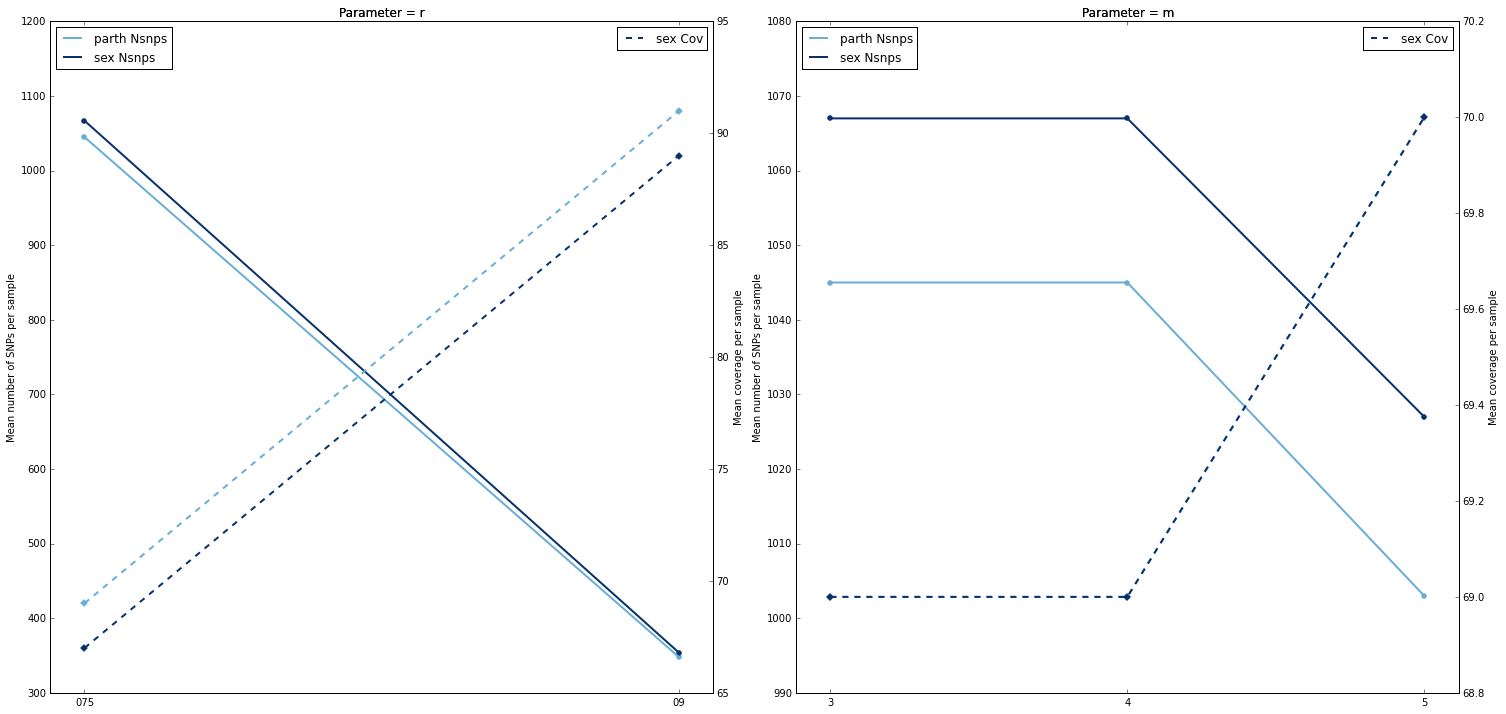

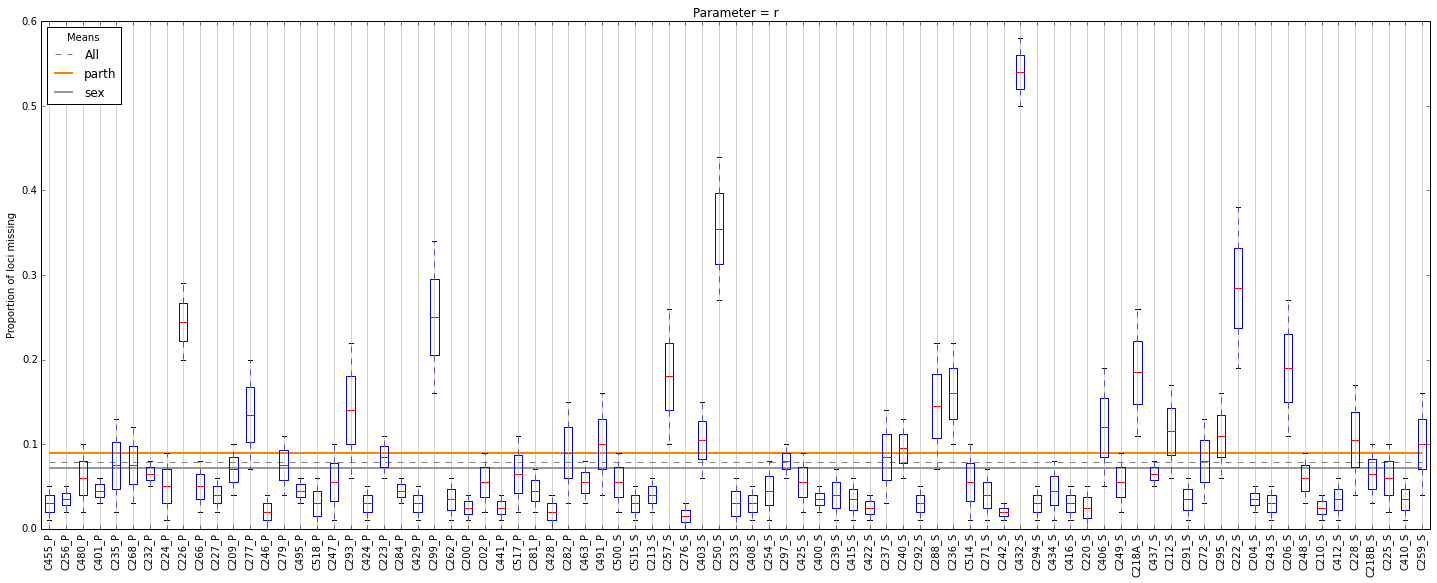

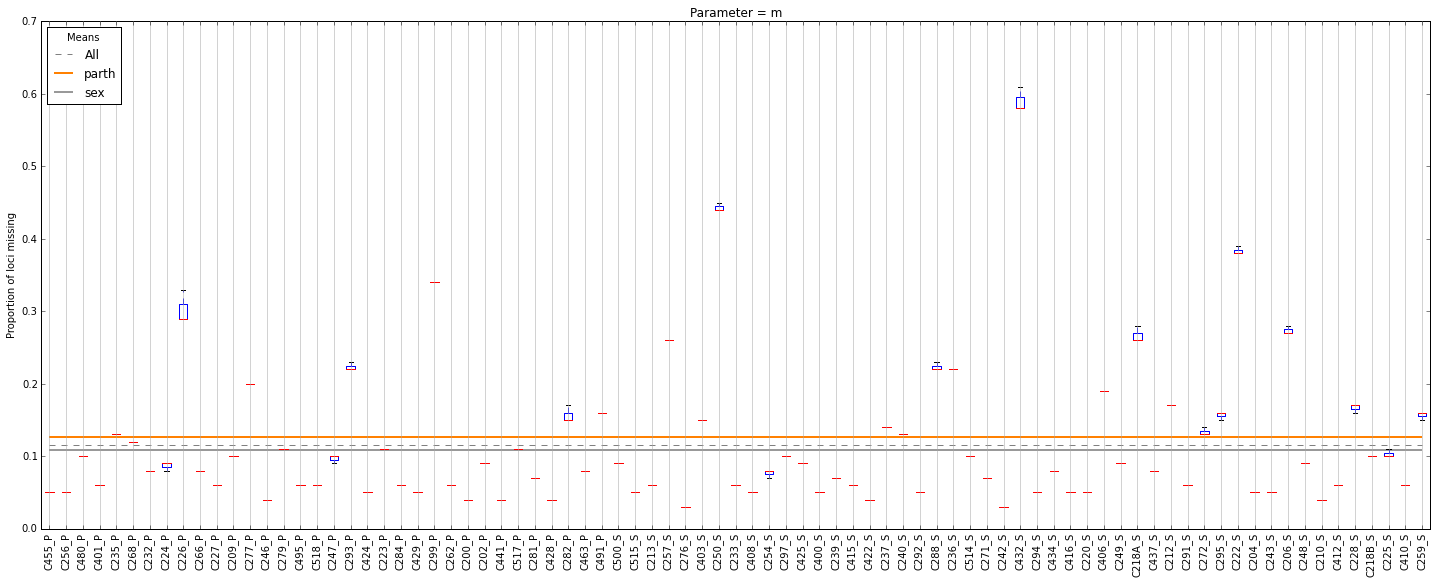

In [40]:
Sample_data, Locus_data, group_info = Incremental_Pop(Analysis_parameters1)

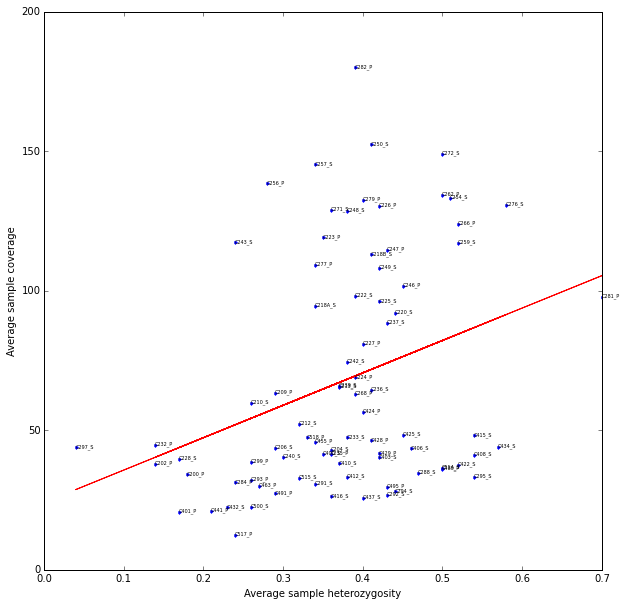

In [53]:
Cov_vs_Het(Sample_data, "m", "3")

In [48]:
help(Cov_vs_Het)

Help on function Cov_vs_Het in module __main__:

Cov_vs_Het(Sample_data, param, value)
    param = the parameter to plot for "p", r" or "m"
    value = the value of the parameter used. Note** For r no decimal place should be used, e.g. 0.75 becomes 075.
    
    Outputs a plot of heterozygosity versus coverage for each sample and plots a regression line. A positive skew in this line suggests that
    low coverage is impacting the ability of stacks to make accurate genotype calls for heterozygous loci.



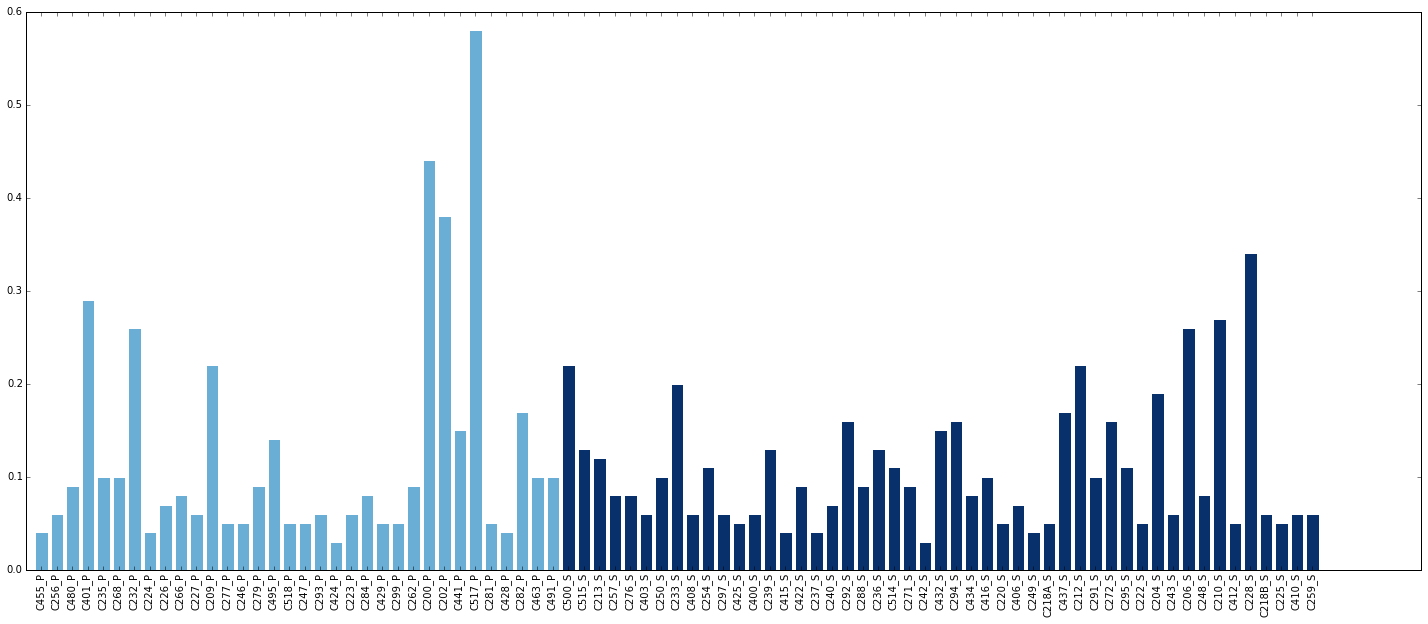

In [61]:
Missing_data_plotter(Sample_data, group_info, "r", "075")